## Compare three types of models
#### LinearRegression, Tree-based, and time-series models

In [58]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib
import torch
import i10_models as m
from sklearn.metrics import root_mean_squared_error
import seaborn as sns

In [60]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))
print(X_full.columns)

X_full type: <class 'pandas.core.frame.DataFrame'> shape: (118700, 31)
Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration',
       'evt_cat_unplanned', 'evt_cat_planned', 'miles', 'curve', 'offramp',
       'onramp', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week',
       'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend', 'evt_total',
       'speed_ratio', 'lag1', 'lag2', 'lag3', 'tt_per_mile',
       'lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile',
       'log_tt_per_mile', 'log_lag1_tt_per_mile', 'log_lag2_tt_per_mile',
       'log_lag3_tt_per_mile'],
      dtype='object')


In [3]:
# load models
lr_path = '../models/lr_models_log.pkl'
tree_path = '../models/tree_models_log.pkl'
xgb_path = '../models/xgb_models_log.pkl'
sarimax_path = '../models/sarimax_results.pkl'
gnn_path = Path('../models/gcn/gcn_lstm_i10_wb/')
lr_res = joblib.load(lr_path)
tree_res = joblib.load(tree_path)
xgb_res = joblib.load(xgb_path)
sarimax_res = joblib.load(sarimax_path)

# Load GNN model and Data object
gnn_pred_file = np.load(gnn_path / 'predictions.npz', allow_pickle=True)
gnn_preds = torch.tensor(gnn_pred_file['preds']) # [2350, 25]
gnn_Y_true = torch.tensor(gnn_pred_file['Y']) # [2374, 25]
SEQ_LEN = int(gnn_pred_file['seq_len'])

data_torch = torch.load(gnn_path / 'data_object.pt', weights_only=False)

# Recreate the model (must match training definition!)
gnn_model = m.GCN_LSTM(
    in_features=data_torch.X.shape[-1],
    gcn_hidden=64,
    lstm_hidden=128,
    out_features=1,
    edge_index=data_torch.edge_index,
    dropout=0.2
)

# Load trained weights
gnn_model.load_state_dict(torch.load(gnn_path / 'model_weights.pth', map_location='cpu'))
gnn_model.eval()

# Print model names
print("Loaded models:")
print(f" - Linear Regression: {lr_res.keys()}")
print(f" - Decision Tree: {tree_res.keys()}")
print(f" - XGBoost: {xgb_res.keys()}")
print(f" - SARIMAX: {sarimax_res['Config'].unique()}")
print(f" - GNN: Predictions loaded: {gnn_preds.shape}, SEQ_LEN={SEQ_LEN}")

Loaded models:
 - Linear Regression: dict_keys(['lr_base', 'lr_base_lags', 'lr_full', 'lr_cyc', 'lr_cyc_lags', 'lr_evt', 'lr_evt_lags', 'ridge_full', 'lasso_full'])
 - Decision Tree: dict_keys(['rf_base', 'rf_base_lags', 'rf_cyc', 'rf_cyc_lags', 'rf_evt', 'rf_evt_lags', 'rf_full', 'gbrt_base', 'gbrt_base_lags', 'gbrt_cyc', 'gbrt_cyc_lags', 'gbrt_evt', 'gbrt_evt_lags', 'gbrt_full'])
 - XGBoost: dict_keys(['xgb_base', 'xgb_base_lags', 'xgb_cyc', 'xgb_cyc_lags', 'xgb_evt', 'xgb_evt_lags', 'xgb_full'])
 - SARIMAX: ['base' 'evt_total' 'evt' 'cyc' 'full']
 - GNN: Predictions loaded: torch.Size([2350, 25]), SEQ_LEN=24


In [4]:
# Unique TMCs (nodes) and timestamps
tmc_order_dict = {
    'WB': ['115P04188', '115+04188', '115P04187', '115+04187', '115P04186', '115+04186', '115P04185', '115+04185', '115P04184', '115+04184', '115P04183', '115+04183', '115P04182', '115+04182', '115P04181', '115+04181', '115P04180', '115+04180', '115P04179', '115+04179', '115P04178', '115+04178', '115P04177', '115+04177', '115P05165'],
    'EB': ['115N04188', '115-04187', '115N04187', '115-04186', '115N04186', '115-04185', '115N04185', '115-04184', '115N04184', '115-04183', '115N04183', '115-04182', '115N04182', '115-04181', '115N04181', '115-04180', '115N04180', '115-04179', '115N04179', '115-04178', '115N04178', '115-04177', '115N04177', '115-05165', '115N05165']
}
time_index = sorted(X_full.index.get_level_values('time_bin').unique())
tmc_order = tmc_order_dict['WB']
N = len(tmc_order) #25
T = len(time_index) #2374

# Chronological split
test_frac = 0.2
n_test = int(T * test_frac)

In [5]:
# quickly compute test RMSE for each model

# get all training and testing target
Y_full = X_full['tt_per_mile'].unstack(level='tmc_code').reindex(columns=tmc_order)[tmc_order].values  # shape [T, N]
Y_train = Y_full[:-n_test, :]  # shape [T - n_test, N]
Y_test = Y_full[-n_test:, :]  # shape [n_test, N]

In [ ]:
# Set up training and testing data

# =====Choose target and exogenous variables=====
TARGET_COL = 'travel_time_seconds'
TMC = '115+04187'
CONFIG_NAME = 'full'  # 'base', 'evt_total', 'evt', 'cyc', 'full'
# =============================================

grp = X_full.xs(TMC, level='tmc_code').sort_index(level='time_bin')
time_series = grp.index.get_level_values('time_bin')
# tmc_miles = grp['miles'].iloc[0]

y_train = grp[TARGET_COL].iloc[:-n_test].values
y_test  = grp[TARGET_COL].iloc[-n_test:].values

# print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")

In [6]:
# Select features based on configuration
time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_cat_unplanned', 'evt_cat_planned']
lag_features = ['log_lag1_tt_per_mile', 'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile']
tmc_features = ['miles', 'reference_speed', 'curve','onramp', 'offramp']
full_features = time_features + evt_features + lag_features + tmc_features

regressors = {
    'base': tmc_features,
    'base_lags': tmc_features + lag_features,
    'full': full_features,
    'cyc':  time_features + tmc_features,
    'cyc_lags':  time_features + tmc_features + lag_features,
    'evt': evt_features + tmc_features,
    'evt_lags':evt_features + tmc_features + lag_features,
}
rmse_results = {}

In [9]:
# heatmap and save results for all models
CANDIDATES = xgb_res
candidates = CANDIDATES.keys()

# Prepare storage for heatmaps
for candidate in candidates:
    model_key = candidate.split('_', 1)[1]
    model = CANDIDATES.get(candidate)

    if model is None:
        print(f"Model {candidate} not found.")
        continue

    print(f"=== {candidate} ===")

    # Build feature matrices for all TMCs and all timesteps
    feature_cols = regressors[model_key]

    preds_full = []
    for tmc in tmc_order:
        grp = X_full.xs(tmc, level='tmc_code').sort_index(level='time_bin')
        X_tmc = grp[feature_cols]
        pred = model.predict(X_tmc)
        preds_full.append(pred)

    preds_full = np.array(preds_full)  # Now shape is [N, T]

    # Now reshape to [T, N]
    preds_2d = preds_full.T
    rmse_results[candidate] = {
        "train": root_mean_squared_error(Y_train, preds_2d[:-n_test, :]),
        "test": root_mean_squared_error(Y_test, preds_2d[-n_test:, :])
    }
    print(f"train RMSE: {rmse_results[candidate]['train']}, test RMSE: {rmse_results[candidate]['test']}")

    # Plot heatmap of predictions
    # m.plot_heatmap_travel_time(
    #     preds=preds_2d,
    #     time_index=time_index,
    #     tmc_order=tmc_order,
    #     title=f"Heatmap – {candidate}",
    #     cmap='plasma',
    #     vmin=40, vmax=110
    # )

=== xgb_base ===
train RMSE: 4.060501413205035, test RMSE: 8.19178651166088
=== xgb_base_lags ===
train RMSE: 3.5579758335247464, test RMSE: 7.659135258353064
=== xgb_cyc ===
train RMSE: 4.021057162469202, test RMSE: 8.204479264166345
=== xgb_cyc_lags ===
train RMSE: 3.4687143695234983, test RMSE: 7.498138626861297
=== xgb_evt ===
train RMSE: 4.038465856122913, test RMSE: 8.192519994683146
=== xgb_evt_lags ===
train RMSE: 3.5603662603109303, test RMSE: 7.659241706059053
=== xgb_full ===
train RMSE: 3.4763049596361504, test RMSE: 7.480108858607207


In [26]:
# manually add cv_rmse from i10_train_lr_tree.ipynb   
rmse_results['xgb_full']["cv_rmse"] = 4.238618
rmse_results['xgb_base']["cv_rmse"] = 5.259884
rmse_results['xgb_evt']["cv_rmse"] = 5.242884
rmse_results['xgb_evt_lags']["cv_rmse"] = 4.447330
rmse_results['xgb_cyc']["cv_rmse"] = 4.813015
rmse_results['xgb_cyc_lags']["cv_rmse"] = 4.267350
rmse_results['xgb_base_lags']["cv_rmse"] = 4.416397
rmse_results['gbrt_cyc_lags']["cv_rmse"] = 4.360668
rmse_results['gbrt_full']["cv_rmse"] = 4.447904
rmse_results['rf_cyc_lags']["cv_rmse"] = 4.472373
rmse_results['rf_full']["cv_rmse"] = 4.478270
rmse_results['rf_base_lags']["cv_rmse"] = 4.575397
rmse_results['rf_evt_lags']["cv_rmse"] = 4.576954
rmse_results['gbrt_evt_lags']["cv_rmse"] = 4.896966
rmse_results['gbrt_base_lags']["cv_rmse"] = 4.917297
rmse_results['rf_cyc']["cv_rmse"] = 4.979059
rmse_results['gbrt_cyc']["cv_rmse"] = 5.193452
rmse_results['rf_evt']["cv_rmse"] = 5.228385
rmse_results['gbrt_evt']["cv_rmse"] = 5.263904
rmse_results['rf_base']["cv_rmse"] = 5.264676
rmse_results['gbrt_base']["cv_rmse"] = 5.266665
rmse_results['lr_cyc_lags']["cv_rmse"] = 4.733156
rmse_results['ridge_full']["cv_rmse"] = 4.735587
rmse_results['lr_full']["cv_rmse"] = 4.735600
rmse_results['lr_base_lags']["cv_rmse"] = 4.788049
rmse_results['lr_evt_lags']["cv_rmse"] = 4.789550
rmse_results['lasso_full']["cv_rmse"] = 4.897246
rmse_results['lr_cyc']["cv_rmse"] = 5.409894
rmse_results['lr_base']["cv_rmse"] = 5.521120
rmse_results['lr_evt']["cv_rmse"] = 5.521322

rmse_results['lstm_full'] = {}
rmse_results['lstm_full']['train'] = 4.221
rmse_results['lstm_full']['test'] = 8.876
rmse_results['lstm_full']['cv_rmse'] = np.sqrt(14.4729)

In [52]:
# GNN training and testing RMSE
# gnn_Y_pred = gnn_preds.squeeze().detach().numpy()  # [2350,25]
# gnn_Y_true = gnn_Y_true.squeeze().detach().numpy()  # [2374, 25]
# gnn_Y_true_test = gnn_Y_true[-n_test:, :]  # Last n_test timestamps
# gnn_Y_pred_test = gnn_Y_pred[-n_test:, :]  # Last n_test timestamps
rmse_results['gnn_full'] = {
    'train': root_mean_squared_error(
        gnn_Y_true[SEQ_LEN:-n_test, :].flatten(),
        gnn_Y_pred[:-n_test, :].flatten()
    ),
    'test': root_mean_squared_error(
        gnn_Y_true_test.flatten(),
        gnn_Y_pred_test.flatten()
    ),
    'cv_rmse': 23.8829**0.5 # during training
}
print(rmse_results['gnn_full'])

{'train': 4.10852575302124, 'test': 10.595697402954102, 'cv_rmse': 4.887013402887289}


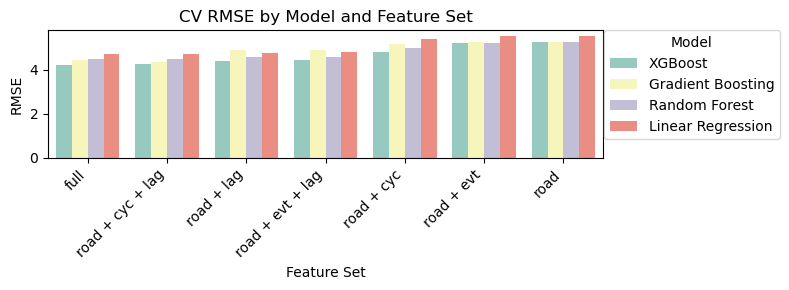

In [53]:
# plot rmse in bar chart
# Example mappings
model_map = {
    'lr': 'Linear Regression',
    'rf': 'Random Forest',
    'xgb': 'XGBoost',
    'gbrt': 'Gradient Boosting',
    'gnn': 'GCN+LSTM',
    'lstm': 'LSTM',
    'ridge': 'Ridge Regression',
    'lasso': 'Lasso Regression'
}

feature_map = {
    'base': 'road',
    'base_lags': 'road + lag',
    'evt': 'road + evt',
    'evt_lags': 'road + evt + lag',
    'cyc': 'road + cyc',
    'cyc_lags': 'road + cyc + lag',
    'full': 'full'
}

df = pd.DataFrame(rmse_results).T
df = df.reset_index().rename(columns={'index': 'model_feat'})
df['model'] = df['model_feat'].str.extract(r'^(lr|rf|xgb|gbrt|gnn|lstm)_?')
df['features'] = df['model_feat'].str.replace(r'^(lr|rf|xgb|gbrt|lstm)_?', '', regex=True)
# Drop ridge/lasso
df = df[~df['model_feat'].isin(['ridge_full', 'lasso_full','gnn_full','lstm_full'])]
# ✅ Apply mappings
df['model'] = df['model'].map(model_map)
df['features'] = df['features'].map(feature_map).fillna(df['features'])

# Melt for plotting
df_melt = df.melt(id_vars=['model', 'features'], value_vars=['train', 'test','cv_rmse'],
                  var_name='dataset', value_name='rmse')

# Sort by RMSE for better visualization (optional)
df_melt = df_melt.sort_values(by='rmse')

# Create the plot
plt.figure(figsize=(8,3))
sns.barplot(
    data=df_melt[df_melt['dataset'] == 'cv_rmse'],  # plot only cv RMSE
    x='features', y='rmse', hue='model',
    palette='Set3'
)

plt.title('CV RMSE by Model and Feature Set')
plt.ylabel('RMSE')
plt.xlabel('Feature Set')
plt.xticks(rotation=45, ha='right')

# Move legend to the right
plt.legend(
    title='Model',
    bbox_to_anchor=(1.002, 1),  # (x, y) coordinates
    loc='upper left',           # anchor location relative to bbox
    borderaxespad=0
)

plt.tight_layout()
plt.show()


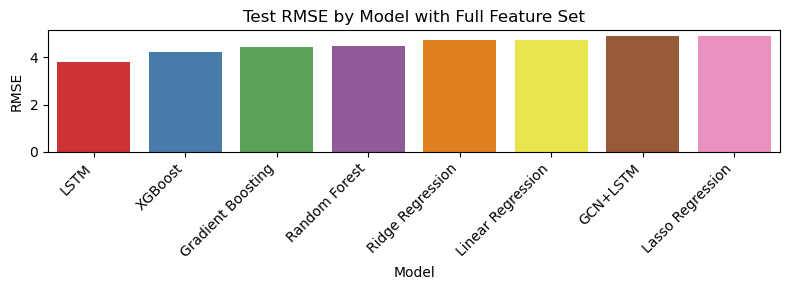

In [57]:
# Compare all the full-feature models
df = pd.DataFrame(rmse_results).T
df = df.reset_index().rename(columns={'index': 'model_feat'})
df['model'] = df['model_feat'].str.extract(r'^(lr|rf|xgb|gbrt|gnn|lstm|ridge|lasso)_?')
df['features'] = df['model_feat'].str.replace(r'^(lr|rf|xgb|gbrt|gnn|lstm|ridge|lasso)_?', '', regex=True)
full_models = ['lr_full','ridge_full', 'lasso_full','rf_full','gbrt_full','xgb_full','gnn_full','lstm_full']
df_full = df[df['model_feat'].isin(full_models)]

# Sort by RMSE for better visualization (optional)
df_full = df_full.sort_values(by='cv_rmse')
df_full['model'] = df_full['model'].map(model_map)

# Create the plot
plt.figure(figsize=(8,3))
sns.barplot(
    data=df_full,  # plot only test RMSE
    x='model', y='cv_rmse', hue='model',
    palette='Set1'
)

plt.title('Test RMSE by Model with Full Feature Set')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


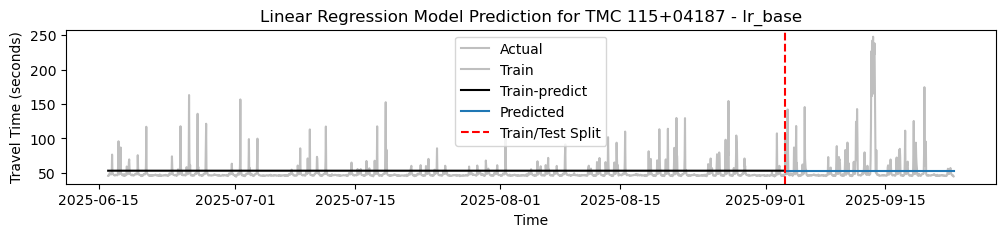

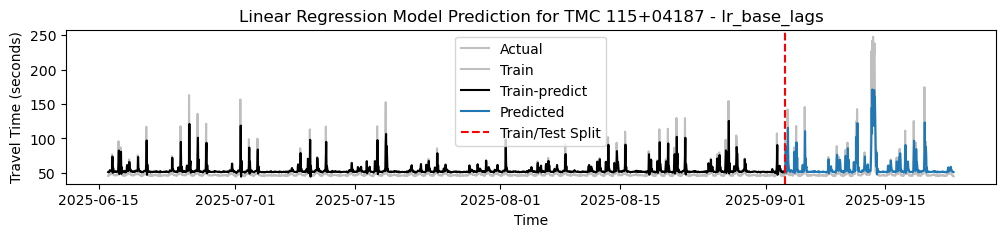

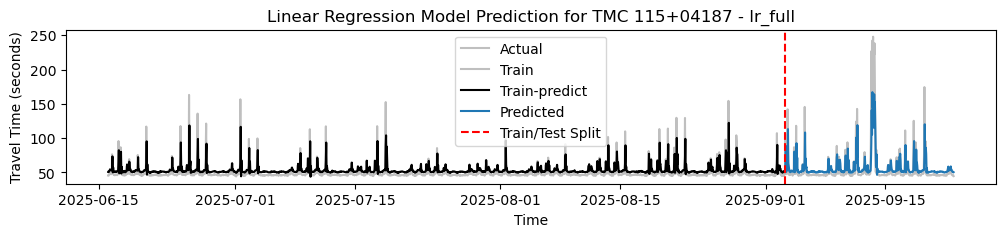

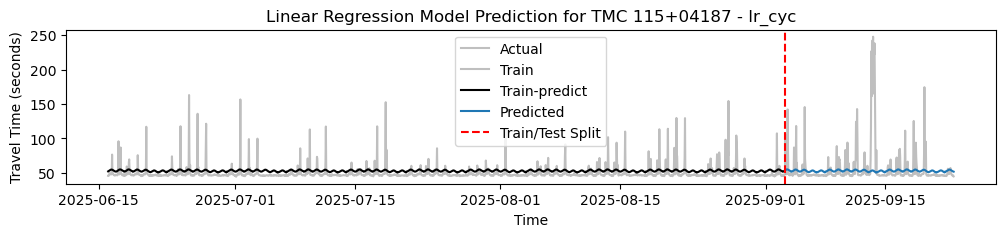

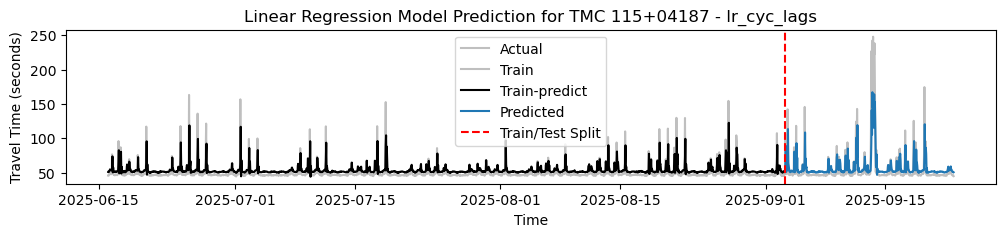

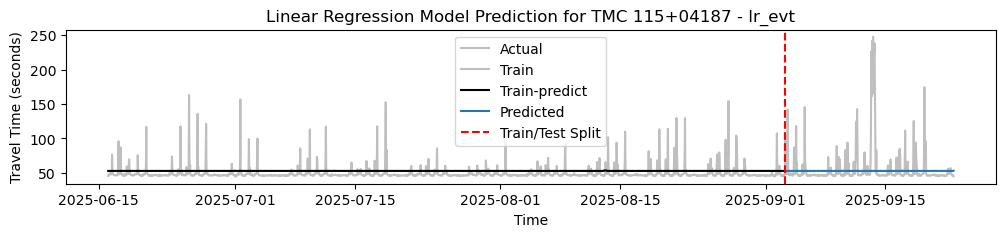

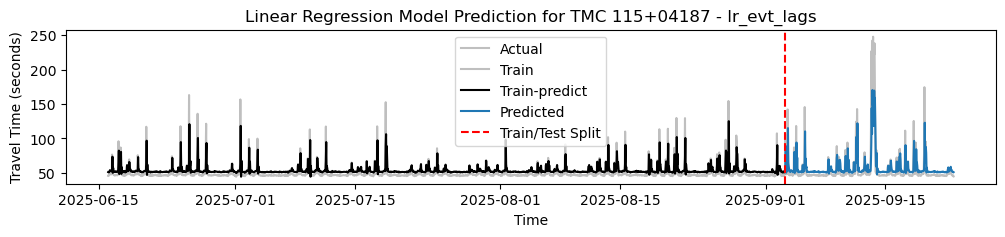

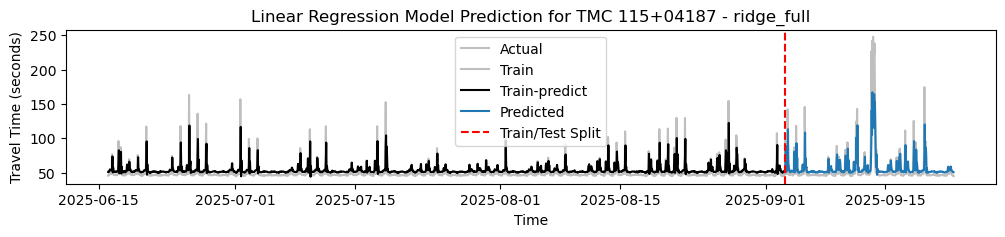

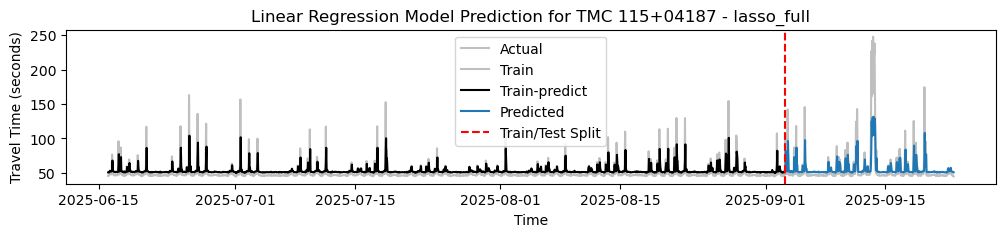

In [ ]:
# Visualize lr model predictions
CANDIDATES = lr_res.keys()

for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    regressor = regressors[candidate.split('_', 1)[1]]
    X_train = grp[regressor].iloc[:-n_test]
    X_test  = grp[regressor].iloc[-n_test:]
    if candidate in lr_res:
        model = lr_res[candidate]
        # print(model.get_params())
        pred_in = model.predict(X_train)
        pred = model.predict(X_test)

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded Linear Regression models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'Linear Regression Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

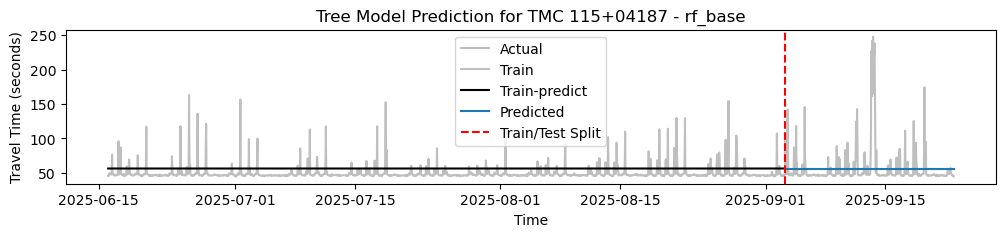

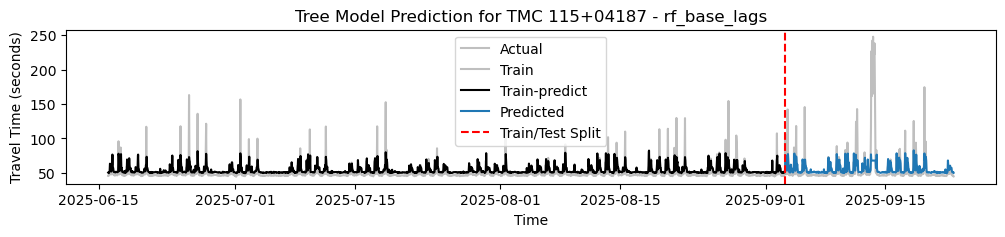

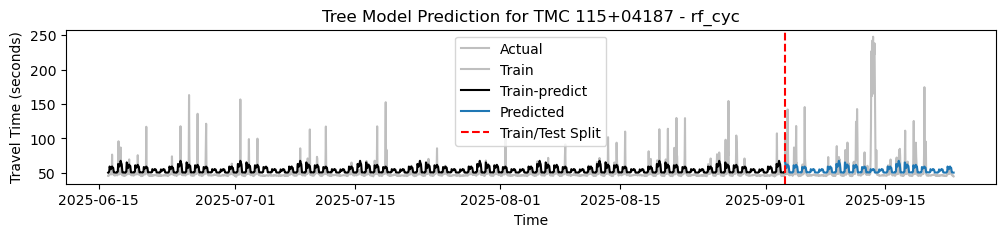

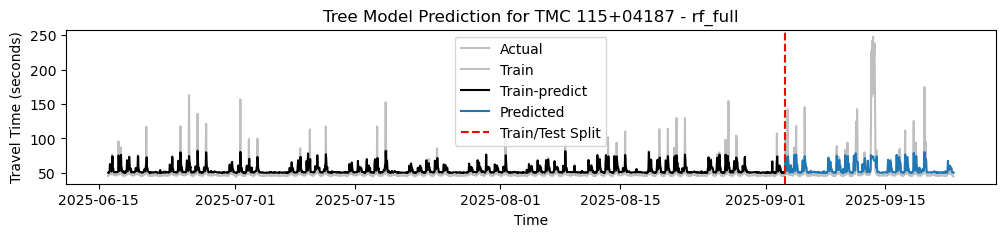

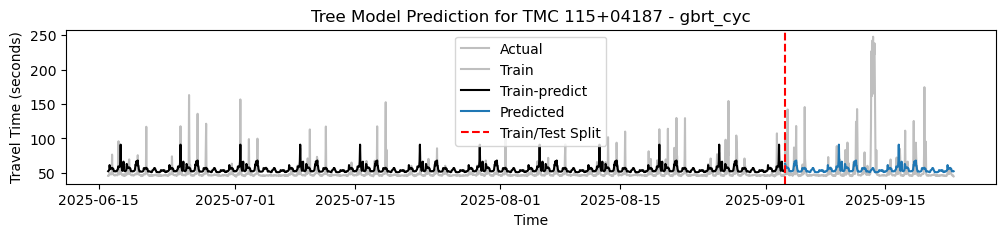

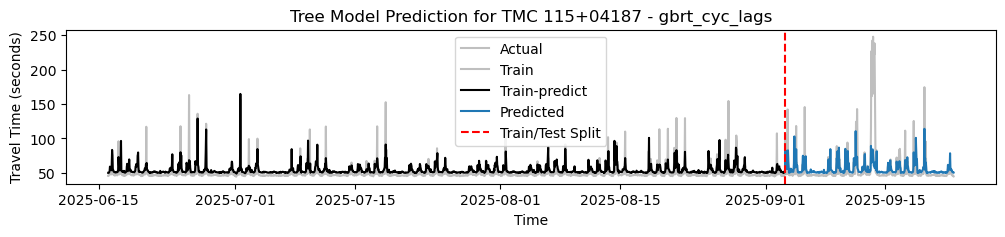

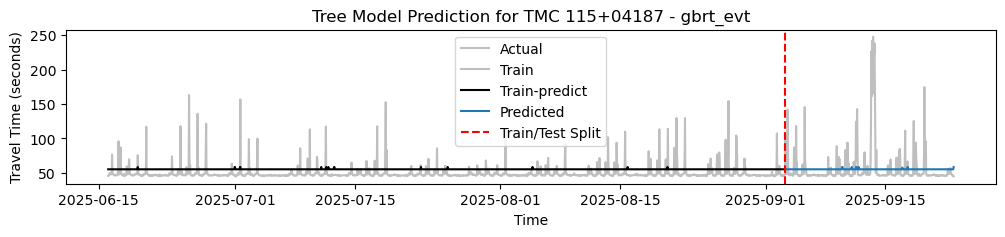

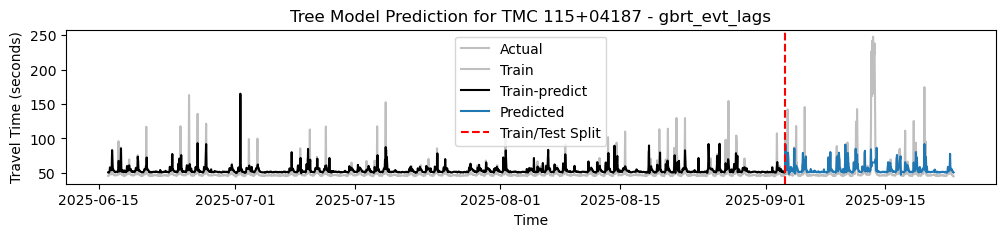

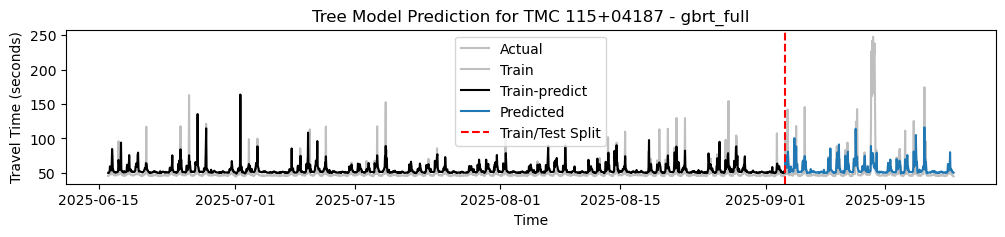

In [16]:
# Visualize tree model predictions
CANDIDATES = ['rf_base', 'rf_base_lags', 'rf_cyc', 'rf_full', 'gbrt_cyc', 'gbrt_cyc_lags', 'gbrt_evt', 'gbrt_evt_lags','gbrt_full']
for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    regressor = regressors[candidate.split('_', 1)[1]]
    X_train = grp[regressor].iloc[:-n_test]
    X_test  = grp[regressor].iloc[-n_test:]
    if candidate in tree_res:
        model = tree_res[candidate]
        # print(model.get_params())
        pred_in = model.predict(X_train)
        pred = model.predict(X_test)

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded Tree models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'Tree Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

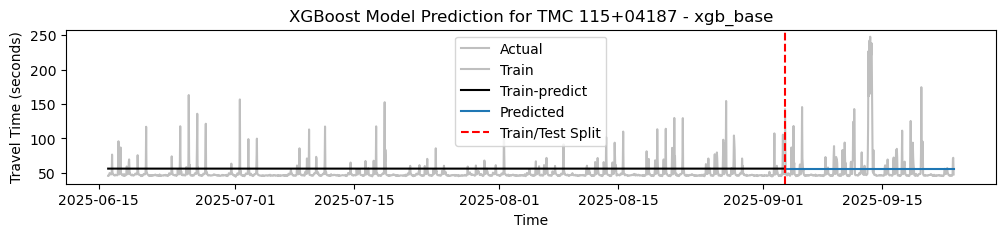

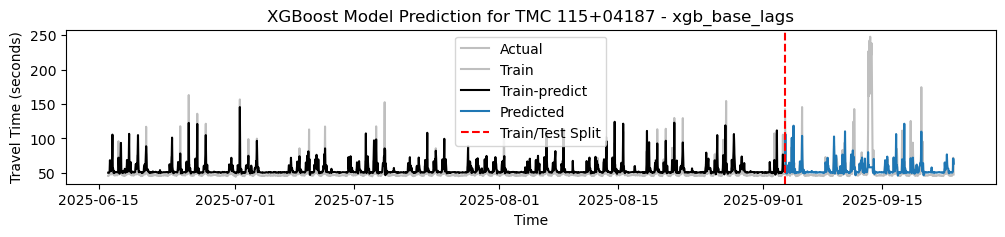

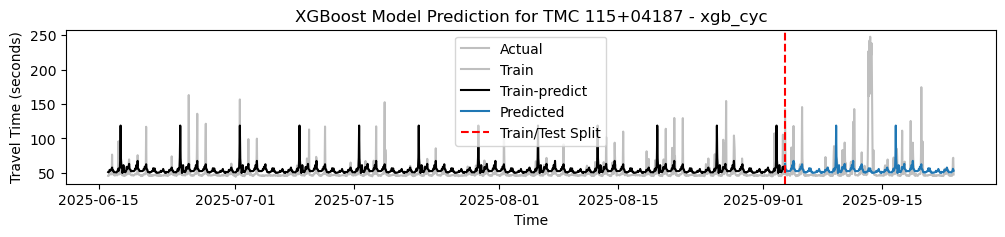

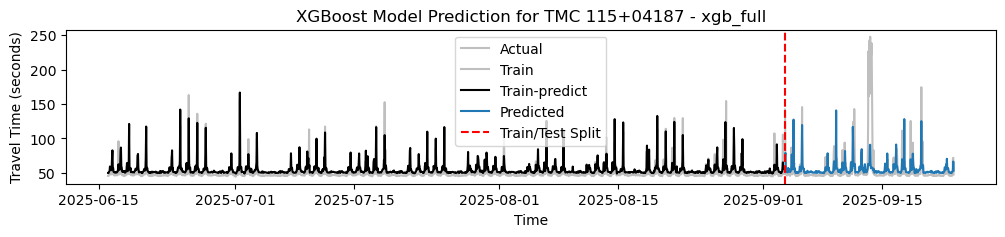

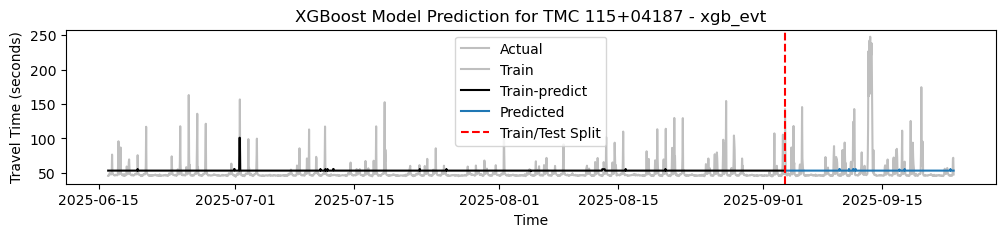

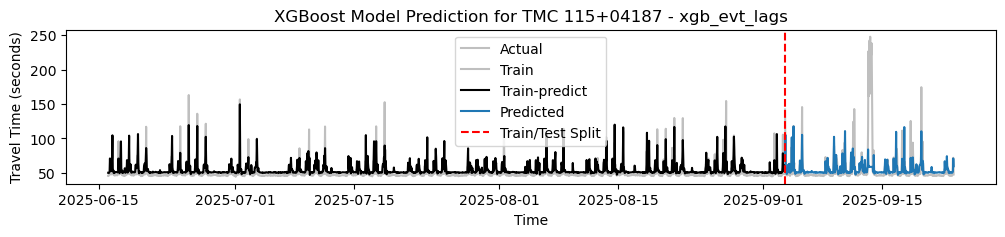

In [15]:
# Visualize XGBoost model predictions
CANDIDATES = ['xgb_base', 'xgb_base_lags', 'xgb_cyc', 'xgb_full', 'xgb_evt', 'xgb_evt_lags']
for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    regressor = regressors[candidate.split('_', 1)[1]]
    X_train = grp[regressor].iloc[:-n_test]
    X_test  = grp[regressor].iloc[-n_test:]
    if candidate in xgb_res:
        model = xgb_res[candidate]
        # print(model.get_params())
        pred_in = model.predict(X_train)
        pred = model.predict(X_test)

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded XGBoost models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'XGBoost Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

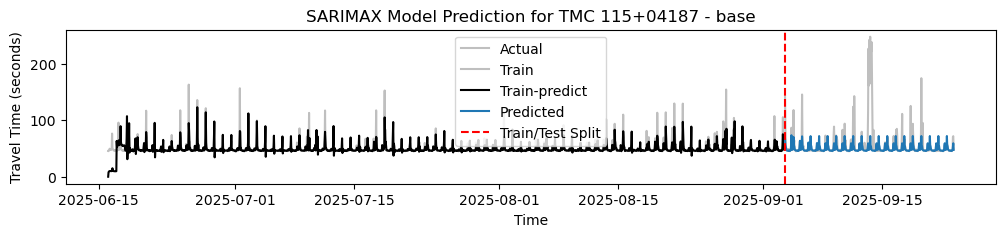

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


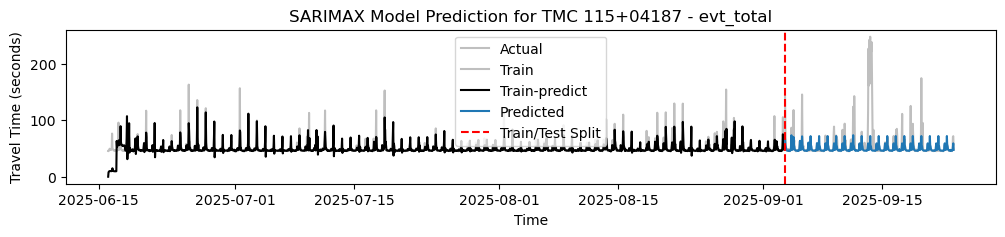

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


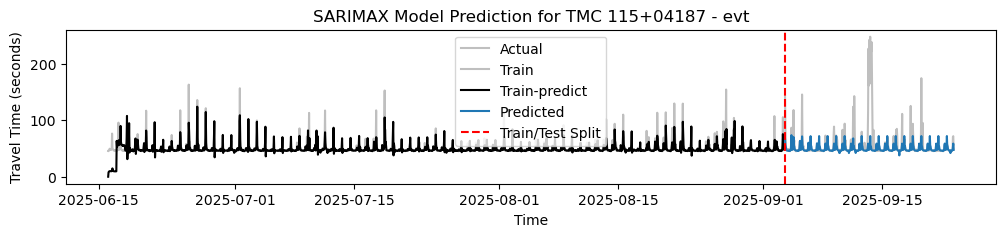

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


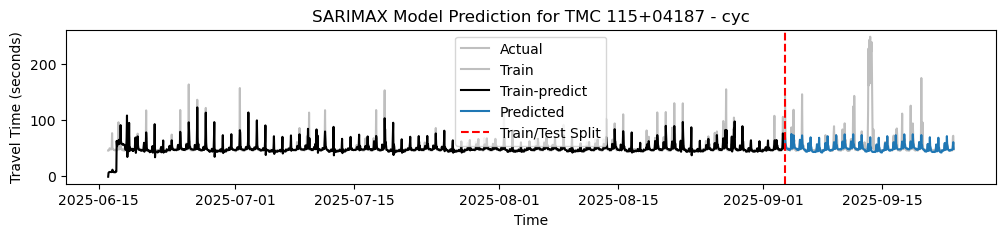

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


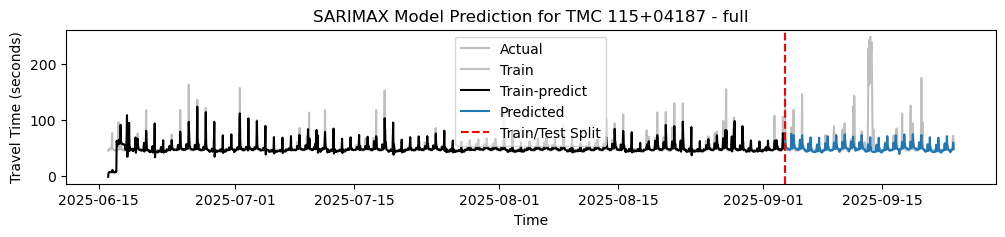

In [43]:
# Visualize time-series model predictions
# Fitting models on the fly will take some time
CANDIDATES = ['base', 'evt_total', 'evt', 'cyc', 'full']
exog_features = {
    "base": None,
    "evt_total": ["evt_total"],
    "evt": ['evt_cat_minor', 'evt_cat_major','evt_cat_closure','evt_cat_obstruction', 'evt_cat_misc'],
    "cyc": ['hour_sin','hour_cos','dow_sin','dow_cos','hour_of_week_sin','hour_of_week_cos','is_weekend'],
    "full": ['evt_cat_minor', 'evt_cat_major','evt_cat_closure','evt_cat_obstruction', 'evt_cat_misc',
            'hour_sin','hour_cos','dow_sin','dow_cos','hour_of_week_sin','hour_of_week_cos','is_weekend']
}
# exog_cols = exog_features[CONFIG_NAME]

for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    if candidate in sarimax_res['Config'].values:
        
        exog = exog_features[candidate]
        if exog is None:
            X_train = None
            X_test = None
        else:
            X_train = grp[exog].iloc[:-n_test]
            X_test  = grp[exog].iloc[-n_test:]

        model = sm.tsa.statespace.SARIMAX(y_train, exog=X_train, order=(1,0,0), seasonal_order=(1,1,1,24),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        pred_in = results.fittedvalues
        pred = results.get_forecast(steps=n_test, exog=X_test).predicted_mean

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded SARIMAX models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'SARIMAX Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

## Interpret feature importance

In [ ]:
import statsmodels.api as sm
def extract_lr_coefficients(model, feature_names):
    """Extract feature coefficients from a fitted linear model inside a pipeline."""
    # Access the underlying LinearRegression estimator
    lr = model.regressor_.named_steps['reg']
    coefs = lr.coef_
    return pd.DataFrame({
        'feature': feature_names,
        'coef': coefs,
        'abs_coef': np.abs(coefs)
    }).sort_values('abs_coef', ascending=False)

def get_lr_importances(model):
    X_train_scaled = model.regressor_.named_steps['pre'].transform(X_train)
    ols = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()
    print(ols.summary())

def get_tree_importances(model, feature_names):
    tree = model.regressor_.named_steps['reg']
    importances = tree.feature_importances_
    return pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

In [7]:
coef_df = extract_lr_coefficients(lr_res['lr_full'], full_features)
display(coef_df.head(10))

tree_df = get_tree_importances(xgb_res['xgb_full'], full_features)
display(tree_df.head(10))

,feature,coef,abs_coef
9,log_lag1_tt_per_mile,0.060599,0.060599
10,log_lag2_tt_per_mile,-0.018072,0.018072
11,log_lag3_tt_per_mile,0.012557,0.012557
1,hour_cos,-0.008593,0.008593
14,curve,0.006054,0.006054
13,reference_speed,0.005998,0.005998
4,hour_of_week_sin,0.005831,0.005831
12,miles,0.005013,0.005013
2,dow_sin,-0.004672,0.004672
0,hour_sin,0.004241,0.004241


,feature,importance
9,log_lag1_tt_per_mile,0.302974
10,log_lag2_tt_per_mile,0.146063
1,hour_cos,0.080227
13,reference_speed,0.063320
16,offramp,0.060669
11,log_lag3_tt_per_mile,0.056196
8,evt_cat_planned,0.047618
2,dow_sin,0.046490
4,hour_of_week_sin,0.044603
0,hour_sin,0.040173
